# Spaceship Titanic Dataset

# Import the library

In [13]:
#!pip install tabpfn 

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Load the Dataset

In [24]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


The data is composed of 14 columns and 8693 entries. We can see all 14 dimensions of our dataset by printing out the first 5 entries using the following code:

In [25]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [17]:
# Display the first 5 examples
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

In [18]:
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Since there are null values, lets complete them mixing 0 and mean. The age will be filled using the mean age and the services will be filled by 0.

<Axes: xlabel='Transported'>

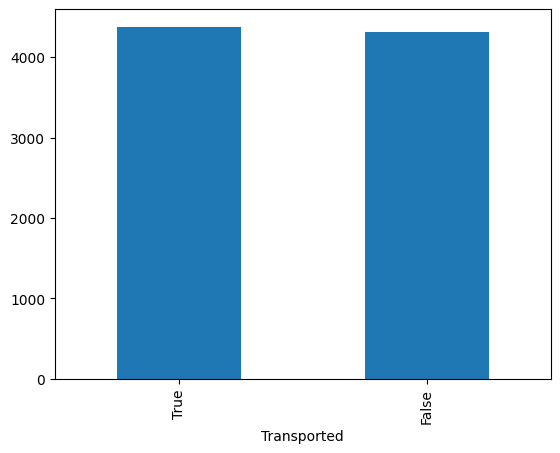

In [19]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

The data seems to be balanced Transported



# Lets do data preprocessing and Feature Engineering

In [26]:
def preprocess_data(df):
    # Convert all Boolean columns
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)
    
    # Encode boolean-like columns
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0}).astype('Int64')
    df['VIP'] = df['VIP'].map({True: 1, False: 0}).astype('Int64')
    
    # One-hot encoding for categorical columns
    df = pd.get_dummies(df, columns=['HomePlanet'], prefix='HomePlanet')
    
    # Handle missing values in Cabin
    df['Cabin'] = df['Cabin'].fillna('Unknown/0/Unknown')
    
    # Split Cabin into Deck, Number, and Side
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df = pd.get_dummies(df, columns=['CabinDeck', 'CabinSide'], prefix=['Deck', 'Side'])
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    
    # One-hot encoding for Destination
    df = pd.get_dummies(df, columns=['Destination'], prefix='Dest')
    
    # Split PassengerId into GroupID and PassengerNum
    df[['GroupID', 'PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['GroupID'] = df['GroupID'].astype(int)
    df['PassengerNum'] = df['PassengerNum'].astype(int)
    
    # Compute group size
    group_sizes = df['GroupID'].value_counts()
    df['GroupSize'] = df['GroupID'].map(group_sizes)
    
    # Fill missing values
    df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    # Drop unnecessary columns
    final_df = df.drop(columns=['Name', 'GroupID', 'PassengerNum', 'PassengerId', 'Cabin'])
    
    return final_df

In [27]:
# Define pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocess_data, validate=False))
])


In [30]:
titanic_df = xgb_pipeline.transform(dataset_df)

/tmp/ipykernel_31/2717586283.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)


# Numerical data distribution

Let us plot all the numerical columns and their value counts:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

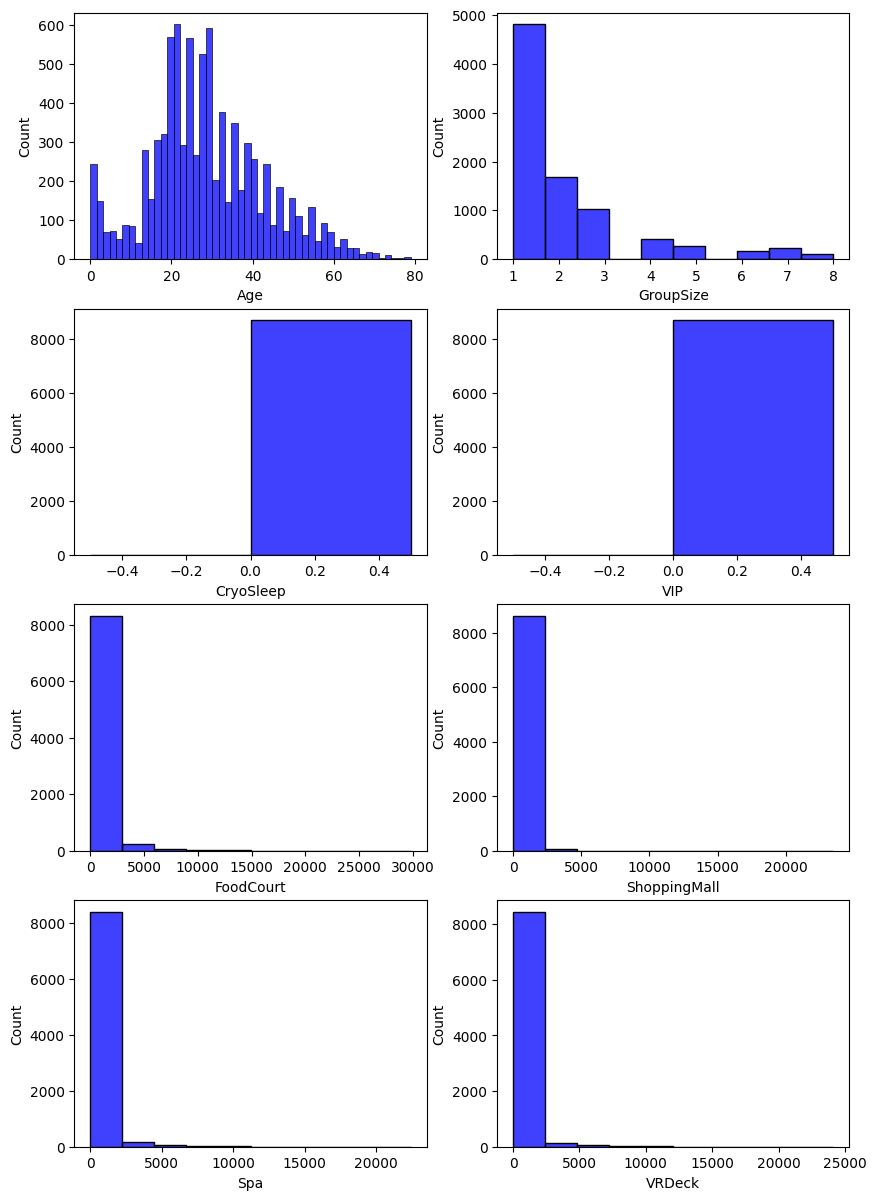

In [31]:
fig, ax = plt.subplots(4,2,  figsize=(10, 6))
plt.subplots_adjust(top = 2)

sns.histplot(titanic_df['Age'], color='b', bins=50, ax=ax[0,0]);
sns.histplot(titanic_df['GroupSize'], color='b', bins=10, ax=ax[0,1]);
sns.histplot(titanic_df['CryoSleep'], color='b', bins=2, ax=ax[1,0]);
sns.histplot(titanic_df['VIP'], color='b', bins=2, ax=ax[1,1]);
sns.histplot(titanic_df['FoodCourt'], color='b', bins=10, ax=ax[2,0]);
sns.histplot(titanic_df['ShoppingMall'], color='b', bins=10, ax=ax[2,1]);
sns.histplot(titanic_df['Spa'], color='b', bins=10, ax=ax[3,0]);
sns.histplot(titanic_df['VRDeck'], color='b', bins=10, ax=ax[3,1]);

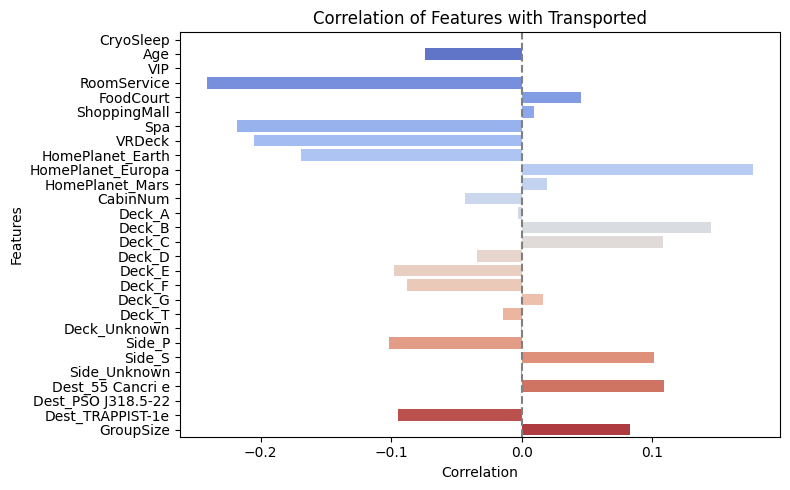

In [32]:
# Select only numeric columns
numeric_df = titanic_df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = titanic_df.corr()

# Extract correlation with 'Transported'
corr_with_target = corr_matrix['Transported'].drop('Transported')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
plt.title('Correlation of Features with Transported')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Spli into Train and Test data

In [ ]:
# Split the target from the features
X = titanic_df.drop(columns=['Transported'])  # Features
y = titanic_df['Transported']  # Target

In [ ]:
# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Selection

#### Univariate Selection (Chi-Squared or ANOVA F-test)

In [66]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)  # top 10 features
X_selected = selector.fit_transform(X_train, y_train)

# Optional: get feature names
selected_features_anova = X_train.columns[selector.get_support()]
print("Selected features:", list(selected_features_anova))

Selected features: ['RoomService', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'Deck_B', 'Deck_C', 'Side_P', 'Side_S', 'Dest_55 Cancri e']


#### Feature Importance from a Model

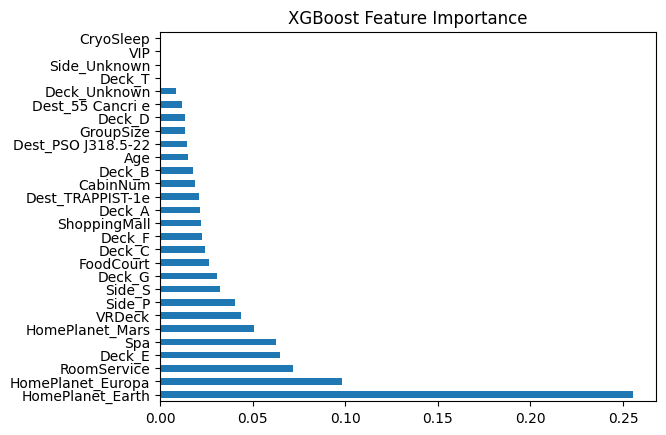

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Plot feature importance
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()

#### Recursive Feature Elimination (RFE)

In [67]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print("RFE selected:", list(selected_features_rfe))

RFE selected: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'CabinNum', 'GroupSize']


# Selection Model

In [55]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'CatBoost': CatBoostClassifier(verbose=0),
    'LightGBM': LGBMClassifier(verbose=-1)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train[selected_features_anova], y_train, cv=5, scoring='accuracy')
    print(f"{name} Accuracy: {scores.mean():.4f}")

XGBoost Accuracy: 0.7764
RandomForest Accuracy: 0.7645
LogisticRegression Accuracy: 0.7823
CatBoost Accuracy: 0.7842
LightGBM Accuracy: 0.7844


In [76]:
for name, model in models.items():
    scores = cross_val_score(model, X_train[selected_features_rfe], y_train, cv=5, scoring='accuracy')
    print(f"{name} Accuracy: {scores.mean():.4f}")

XGBoost Accuracy: 0.7758
RandomForest Accuracy: 0.7762
LogisticRegression Accuracy: 0.7834
CatBoost Accuracy: 0.7880
LightGBM Accuracy: 0.7866
